In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import scipy
import scipy.io as sio
from utility_functions import sparsifyDynamics, poolData

In [73]:
from matplotlib import style
style.use('dark_background')

In [118]:
# load saved data from .mat file
data = sio.loadmat('../models/data/REFSIM-25hr.mat', chars_as_strings=1)
t = data['t']
x = data['x']
names = data['names']
names = np.array([str(''.join(letter)) for letter_array in names for letter in letter_array])

# only keep non-constant data
dynamics = [0,1,2,3,4,5,6,7,8,9]
x = x[:, dynamics]
names = names[dynamics]
names = ['Art', 'Gut', 'GutL', 'Lung', 'Ven', 'Rest', 'Liver', 'Metab', 'Kidney', 'Tubules']

# scale all data from Mol/L to MilliMols/L
x *= 1000

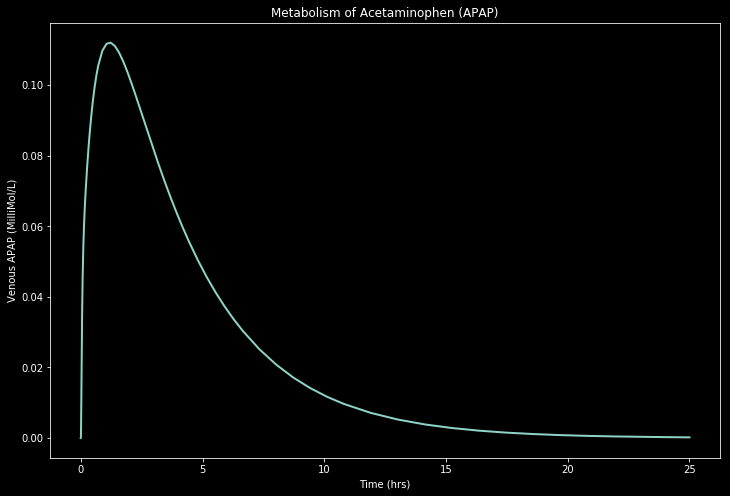

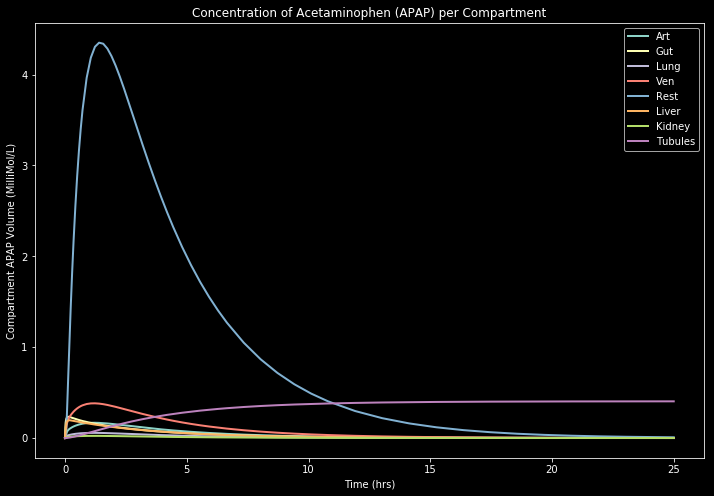

In [119]:
# plot the amount of APAP in venous blood over time
venousAPAPInLiters = x[:, 4] / 3.41;
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, venousAPAPInLiters, '-', linewidth=2)
plt.xlabel('Time (hrs)')
plt.ylabel('Venous APAP (MilliMol/L)')
plt.title('Metabolism of Acetaminophen (APAP)')
plt.show()

compartments = [0,1,3,4,5,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], linewidth=2, label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel('Compartment APAP Volume (MilliMol/L)')
plt.title('Concentration of Acetaminophen (APAP) per Compartment')
ax.legend(loc='upper right')
plt.show()

In [125]:
# Run SINDy algorithm
xdf = pd.DataFrame(x)
n, nVars = x.shape
xdf_dot = xdf.diff()

# we lose one row, need to zero pad (or maybe not)
#x_dot = pd.concat([pd.DataFrame(np.zeros((1, nVars))), x_dot])
xdf_dot.loc[0, :] = 0.0

# variable labeling
cols = [i for i in names]
xdf.columns = cols
dot_labels = pd.Index([s for s in cols])

# SINDy params
polyorder = 4
lam = 0.00001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(xdf, nVars, polyorder, usesine)

# run SINDy
xdf_hat = sparsifyDynamics(Theta, xdf_dot, lam)
xdf_hat = xdf_hat.set_index(dot_labels)
print(xdf_hat.shape)
# xdf_hat = xdf_hat.iloc[:, 1:]
# print(xdf_hat.shape)
# xdf_hat.columns = dot_labels
# print(dot_labels)
# print(cols)
# Xhat_df.columns = cols


(10, 1001)


In [126]:
# Display result
xdf_hat.T

,Art,Gut,GutL,Lung,Ven,Rest,Liver,Metab,Kidney,Tubules
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000
Art,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000e+00,0.0,0.000000
Gut,0.000000,0.000000,-0.042439,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,-0.000000
GutL,0.000000,0.000000,-0.000000,0.000000,0.000083,0.000000,0.000000,-0.000000e+00,0.0,-0.000117
Lung,-0.000000,-0.009212,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000e+00,0.0,0.000000
Ven,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000e+00,0.0,0.000000
Rest,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000e+00,-0.0,0.000000
Liver,0.000000,-0.000000,-0.007523,0.000000,0.000000,0.000000,-0.000000,0.000000e+00,0.0,-0.000000
Metab,-0.000055,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000e+00,-0.0,0.000000
Kidney,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000e+00,0.0,0.000000


In [124]:
xdf_hat.to_csv('../models/data/dynamics.csv')